<a href="https://colab.research.google.com/github/TonyCCintra/projeto-dio-chatgpt-clone/blob/main/Treinamento_Redes_Neurais_com_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Instalar o TensorFlow Datasets (geralmente já vem, mas garante)
!pip install -q tensorflow_datasets

# Importar as bibliotecas necessárias
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

print("TensorFlow Version:", tf.__version__)
print("TensorFlow Datasets Version:", tfds.__version__)

TensorFlow Version: 2.18.0
TensorFlow Datasets Version: 4.9.8


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.BIS5RZ_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Número de exemplos de Treinamento: 18610
Número de exemplos de Validação: 4652
Classes: ['Gato', 'Cachorro']


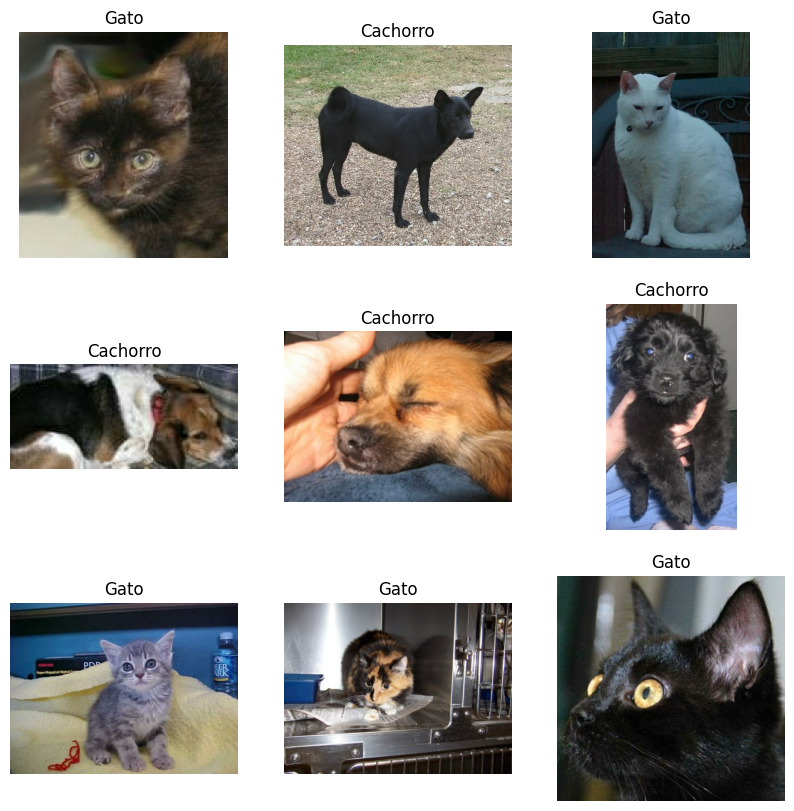

In [9]:
# Carregar o dataset 'cats_vs_dogs' do TensorFlow Datasets
# Dividindo o split 'train' em 80% para treino e 20% para validação
(train_dataset_raw, validation_dataset_raw), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'], # Divide em 80% treino, 20% validação
    shuffle_files=True, # Embaralha os arquivos (bom para distribuição)
    as_supervised=True, # Retorna tuplas (imagem, rótulo)
    with_info=True,     # Inclui informações sobre o dataset
)

# Imprimir informações sobre os datasets
num_train_examples = ds_info.splits['train[:80%]'].num_examples
num_validation_examples = ds_info.splits['train[80%:]'].num_examples
print(f"Número de exemplos de Treinamento: {num_train_examples}")
print(f"Número de exemplos de Validação: {num_validation_examples}")

# Nomes das classes (Gato=0, Cachorro=1, por padrão no tfds para este dataset)
# Vamos verificar isso explicitamente se necessário, mas geralmente é essa a ordem.
CLASS_NAMES = ['Gato', 'Cachorro']
print("Classes:", CLASS_NAMES)

# Visualizar algumas imagens do dataset de treinamento
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset_raw.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(CLASS_NAMES[label])
  plt.axis("off")
plt.show()

In [10]:
IMG_SIZE = 224 # Tamanho de imagem esperado pelo MobileNetV2
BATCH_SIZE = 32  # Número de imagens processadas em cada passo do treino

# Função para formatar/pré-processar uma imagem
def format_image(image, label):
  # Redimensiona a imagem para IMG_SIZE x IMG_SIZE
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  # Normaliza os pixels para o intervalo [-1, 1] usando a função do MobileNetV2
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  return image, label

# Aplicar a função de formatação a todos os exemplos nos datasets
train_dataset = train_dataset_raw.map(format_image)
validation_dataset = validation_dataset_raw.map(format_image)

# Configurar os datasets para performance:
# 1. Embaralhar o dataset de treino
# 2. Criar batches de imagens
# 3. Pré-buscar dados (prefetch) para carregar o próximo batch enquanto o atual é processado

BUFFER_SIZE = 1000 # Tamanho do buffer para embaralhamento

train_batches = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = validation_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Verificar a forma de um batch (Lote, Altura, Largura, Canais) e do rótulo (Lote,)
for image_batch, label_batch in train_batches.take(1):
   pass # Apenas para pegar um batch

print("Forma do batch de imagens:", image_batch.shape)
print("Forma do batch de rótulos:", label_batch.shape)

Forma do batch de imagens: (32, 224, 224, 3)
Forma do batch de rótulos: (32,)


In [11]:
# Definir a forma de entrada das imagens
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3) # (Altura, Largura, Canais de Cor)

# Carregar o modelo base MobileNetV2 pré-treinado no ImageNet
# include_top=False: Remove a camada de classificação final do ImageNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Congelar os pesos do modelo base
# Não queremos treinar as camadas convolucionais já treinadas do MobileNetV2
base_model.trainable = False

# Ver a arquitetura do modelo base (opcional, pode gerar muita saída)
# base_model.summary()

# Construir nosso modelo em cima do base_model
# Usaremos a API Funcional do Keras

# Define a entrada do modelo
inputs = tf.keras.Input(shape=IMG_SHAPE)

# Passa a entrada pelo modelo base (que está congelado)
x = base_model(inputs, training=False) # Importante: training=False aqui

# Adiciona camadas no topo para a nossa classificação específica
# 1. Camada de Pooling para reduzir as features
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# 2. Camada de Dropout para regularização (previne overfitting)
x = tf.keras.layers.Dropout(0.2)(x)
# 3. Camada Densa final com 1 neurônio (classificação binária) e ativação sigmoid
#    A saída será um valor entre 0 (Gato) e 1 (Cachorro)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Criar o modelo final
model = tf.keras.Model(inputs, outputs)

# Ver a arquitetura do nosso modelo final
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Definir a taxa de aprendizado (learning rate)
# Uma taxa menor é geralmente boa para começar com Transfer Learning
base_learning_rate = 0.0001

# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(), # ou from_logits=False se a última camada TEM sigmoid
              metrics=['accuracy'])

print("Modelo compilado com sucesso!")

Modelo compilado com sucesso!


In [13]:
model.save('meu_modelo_gatos_caes.h5')
print("Modelo salvo como meu_modelo_gatos_caes.h5")

Modelo salvo como meu_modelo_gatos_caes.h5


In [14]:
# Definir o número de épocas (passagens completas pelo dataset de treino)
initial_epochs = 10

# Medir o tempo de treinamento (opcional)
import time
start_time = time.time()

# Treinar o modelo
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches) # Usamos os batches de validação aqui

end_time = time.time()
print(f"\nTreinamento concluído em {(end_time - start_time):.2f} segundos")

Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 943s 2s/step - accuracy: 0.8337 - loss: 0.3962 - val_accuracy: 0.9772 - val_loss: 0.1060
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 943s 2s/step - accuracy: 0.9742 - loss: 0.1016 - val_accuracy: 0.9834 - val_loss: 0.0673
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 961s 2s/step - accuracy: 0.9817 - loss: 0.0683 - val_accuracy: 0.9877 - val_loss: 0.0535
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 942s 2s/step - accuracy: 0.9832 - loss: 0.0583 - val_accuracy: 0.9877 - val_loss: 0.0465
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 928s 2s/step - accuracy: 0.9855 - loss: 0.0492 - val_accuracy: 0.9873 - val_loss: 0.0422
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1002s 2s/step - accuracy: 0.9870 - loss: 0.0473 - val_accuracy: 0.9880 - val_loss: 0.0394
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 972s 2s/step - accuracy: 0.9861 - loss: 0.0439 - val_accuracy: 0.9873 - val_loss: 0.0375
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 947s 2s/step - accuracy: 0.9876 - loss: 0.0410 - val_acc

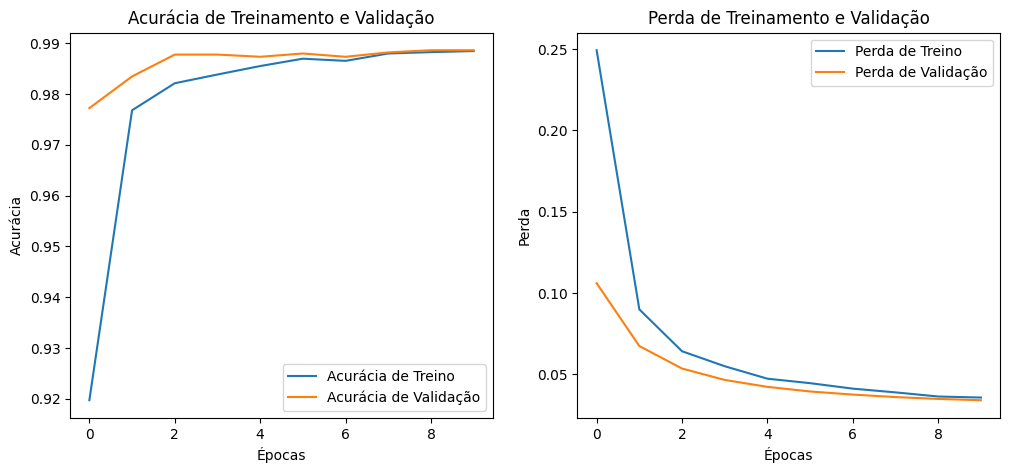


Avaliação final no conjunto de validação:
146/146 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9889 - loss: 0.0328
Perda na Validação: 0.03401476889848709
Acurácia na Validação: 0.9886070489883423


In [15]:
# Obter as métricas de treino e validação do histórico
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

# Plotar Acurácia de Treino e Validação
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

# Plotar Perda de Treino e Validação
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.show()

# Avaliar o modelo final no conjunto de validação
print("\nAvaliação final no conjunto de validação:")
loss, accuracy = model.evaluate(validation_batches)
print("Perda na Validação:", loss)
print("Acurácia na Validação:", accuracy)

In [16]:
# Salvar o modelo treinado
model.save('meu_modelo_gatos_caes.h5') # Salva arquitetura, pesos e config. do otimizador
print("Modelo salvo como meu_modelo_gatos_caes.h5")

# OU Apenas salvar os pesos:
# model.save_weights('meu_modelo_gatos_caes_pesos.h5')
# print("Pesos do modelo salvos como meu_modelo_gatos_caes_pesos.h5")

Modelo salvo como meu_modelo_gatos_caes.h5


In [19]:
# ... (código anterior do Passo 4) ...
model = tf.keras.Model(inputs, outputs)
# ...

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


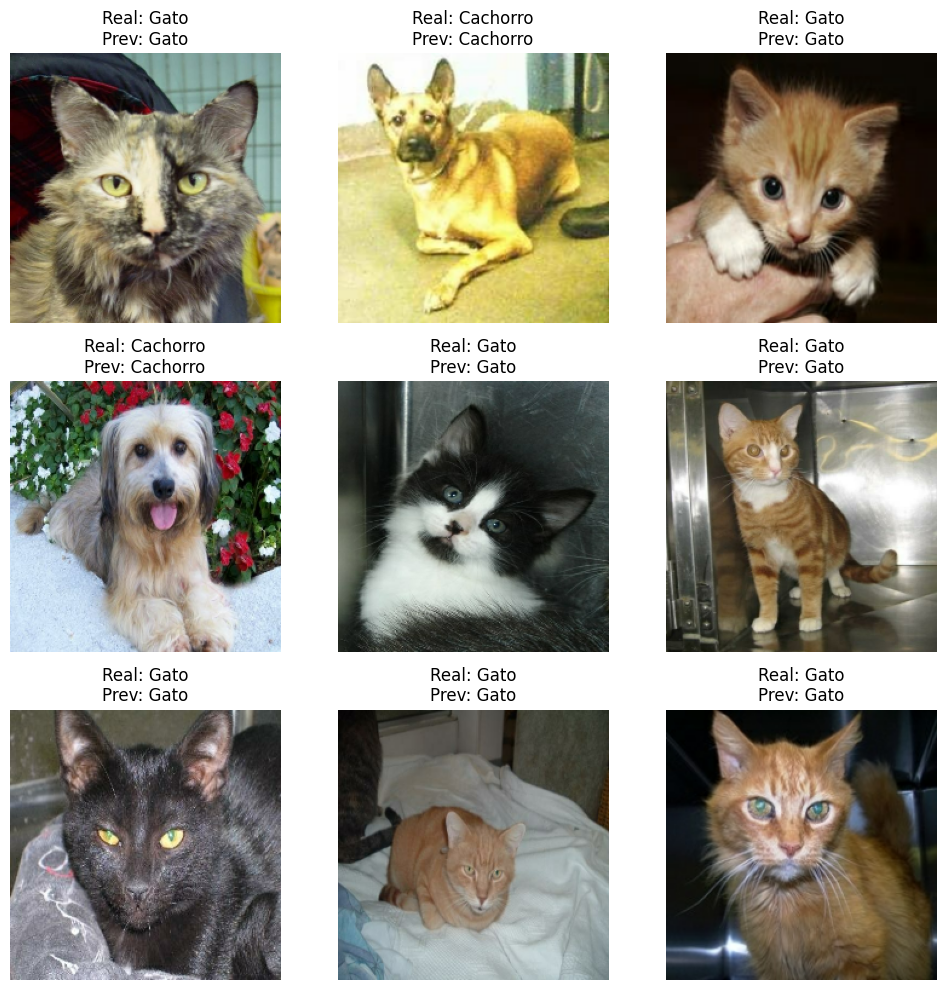

In [20]:
# Pegar um batch do dataset de validação
image_batch_val, label_batch_val = next(iter(validation_batches))

# Fazer previsões
predictions_raw = model.predict(image_batch_val)

# A saída da sigmoide é uma probabilidade entre 0 e 1.
# Vamos converter para 0 (Gato) ou 1 (Cachorro) usando um limiar de 0.5
predicted_labels = (predictions_raw > 0.5).astype(int).flatten() # flatten para tornar um array 1D

# Comparar com os rótulos reais
actual_labels = label_batch_val.numpy()

# Mostrar algumas previsões
plt.figure(figsize=(10, 10))
for i in range(9): # Mostrar as primeiras 9 imagens do batch
  ax = plt.subplot(3, 3, i + 1)
  # Precisamos desnormalizar a imagem para visualização (aproximado)
  img_display = (image_batch_val[i] * 127.5 + 127.5).numpy().astype("uint8")
  plt.imshow(img_display)
  prediction_class = CLASS_NAMES[predicted_labels[i]]
  actual_class = CLASS_NAMES[actual_labels[i]]
  plt.title(f"Real: {actual_class}\nPrev: {prediction_class}")
  plt.axis("off")
plt.tight_layout() # Ajusta o espaçamento
plt.show()

In [21]:
# Descongelar o base_model
base_model.trainable = True

# Quantas camadas descongelar? Vamos começar com as últimas 30, por exemplo.
# É importante não descongelar tudo de uma vez com uma taxa alta.
fine_tune_at = len(base_model.layers) - 30 # Exemplo: descongelar as últimas 30 camadas

# Congelar todas as camadas ANTES da camada `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompilar o modelo com uma taxa de aprendizado MUITO BAIXA
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), # Taxa bem menor
              metrics=['accuracy'])

# model.summary() # Ver quais camadas estão treináveis

# Continuar o treinamento (fine-tuning)
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1] + 1, # Continua de onde parou
                         validation_data=validation_batches)

Epoch 11/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 1173s 2s/step - accuracy: 0.9519 - loss: 0.1286 - val_accuracy: 0.9858 - val_loss: 0.0417
Epoch 12/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 1179s 2s/step - accuracy: 0.9846 - loss: 0.0434 - val_accuracy: 0.9890 - val_loss: 0.0337
Epoch 13/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 1209s 2s/step - accuracy: 0.9880 - loss: 0.0349 - val_accuracy: 0.9899 - val_loss: 0.0313
Epoch 14/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 1161s 2s/step - accuracy: 0.9873 - loss: 0.0340 - val_accuracy: 0.9901 - val_loss: 0.0315
Epoch 15/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 1167s 2s/step - accuracy: 0.9895 - loss: 0.0264 - val_accuracy: 0.9893 - val_loss: 0.0333
Epoch 16/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 1160s 2s/step - accuracy: 0.9931 - loss: 0.0200 - val_accuracy: 0.9897 - val_loss: 0.0331
Epoch 17/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 1131s 2s/step - accuracy: 0.9942 - loss: 0.0167 - val_accuracy: 0.9895 - val_loss: 0.0344
Epoch 18/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 1122s 2s/step - accuracy: 0.9952 - loss: 0

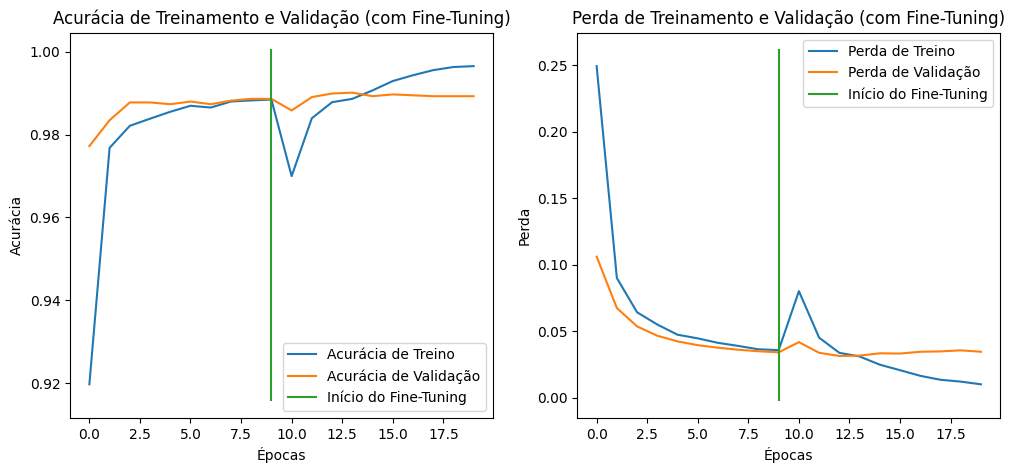

In [22]:
# Obter as métricas do treino inicial (se ainda não as tiver em 'acc', 'val_acc', etc.)
# Se a variável 'history' da primeira fase de treino ainda existir:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Adicionar as métricas do fine-tuning
# Se você chamou o resultado do fit de fine-tuning de 'history_fine':
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# Calcular o range total de épocas
# initial_epochs foi o número de épocas do primeiro treino
# fine_tune_epochs foi o número de épocas do fine-tuning
# total_epochs = initial_epochs + fine_tune_epochs (se você definiu assim)
# Ou podemos pegar o tamanho da lista de acurácia:
epochs_range_total = range(len(acc))


# Plotar Acurácia de Treino e Validação (Combinada)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_total, acc, label='Acurácia de Treino')
plt.plot(epochs_range_total, val_acc, label='Acurácia de Validação')
# Adicionar uma linha vertical para marcar o início do fine-tuning
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Início do Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Acurácia de Treinamento e Validação (com Fine-Tuning)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

# Plotar Perda de Treino e Validação (Combinada)
plt.subplot(1, 2, 2)
plt.plot(epochs_range_total, loss, label='Perda de Treino')
plt.plot(epochs_range_total, val_loss, label='Perda de Validação')
# Adicionar uma linha vertical para marcar o início do fine-tuning
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Início do Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Perda de Treinamento e Validação (com Fine-Tuning)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.show()

In [23]:
print("\nAvaliação final (pós Fine-Tuning) no conjunto de validação:")
loss_ft, accuracy_ft = model.evaluate(validation_batches)
print("Perda na Validação (Pós Fine-Tuning):", loss_ft)
print("Acurácia na Validação (Pós Fine-Tuning):", accuracy_ft)


Avaliação final (pós Fine-Tuning) no conjunto de validação:
146/146 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9893 - loss: 0.0303
Perda na Validação (Pós Fine-Tuning): 0.03444338217377663
Acurácia na Validação (Pós Fine-Tuning): 0.9892519116401672


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


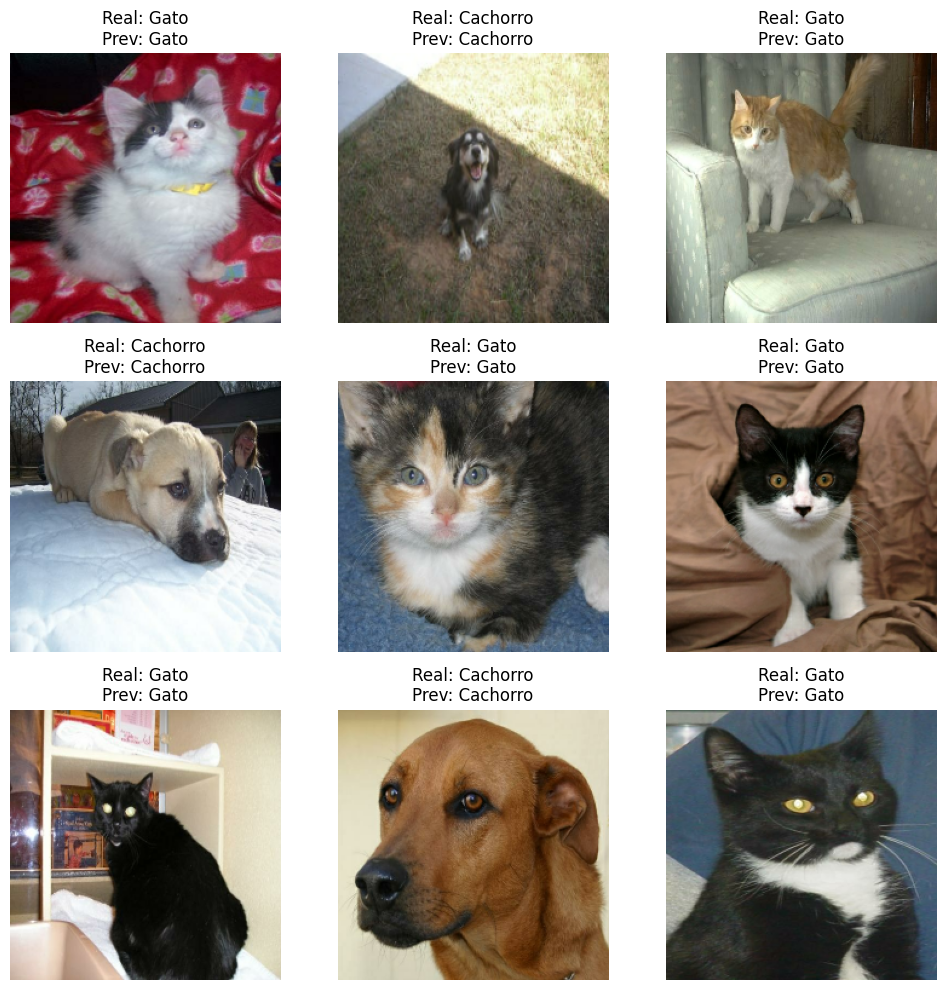

In [24]:
# Código do Passo 8 (para sua conveniência, se precisar copiar novamente)
image_batch_val, label_batch_val = next(iter(validation_batches))
predictions_raw = model.predict(image_batch_val)
predicted_labels = (predictions_raw > 0.5).astype(int).flatten()
actual_labels = label_batch_val.numpy()

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img_display = (image_batch_val[i] * 127.5 + 127.5).numpy().astype("uint8")
  plt.imshow(img_display)
  prediction_class = CLASS_NAMES[predicted_labels[i]]
  actual_class = CLASS_NAMES[actual_labels[i]]
  plt.title(f"Real: {actual_class}\nPrev: {prediction_class}")
  plt.axis("off")
plt.tight_layout()
plt.show()

In [25]:
# Salvar o modelo após o fine-tuning
model.save('meu_modelo_gatos_caes_finetuned.h5') # ou .keras para o novo formato
# Ou sobrescreva o anterior se preferir:
# model.save('meu_modelo_gatos_caes.h5')
print("Modelo pós fine-tuning salvo!")

Modelo pós fine-tuning salvo!


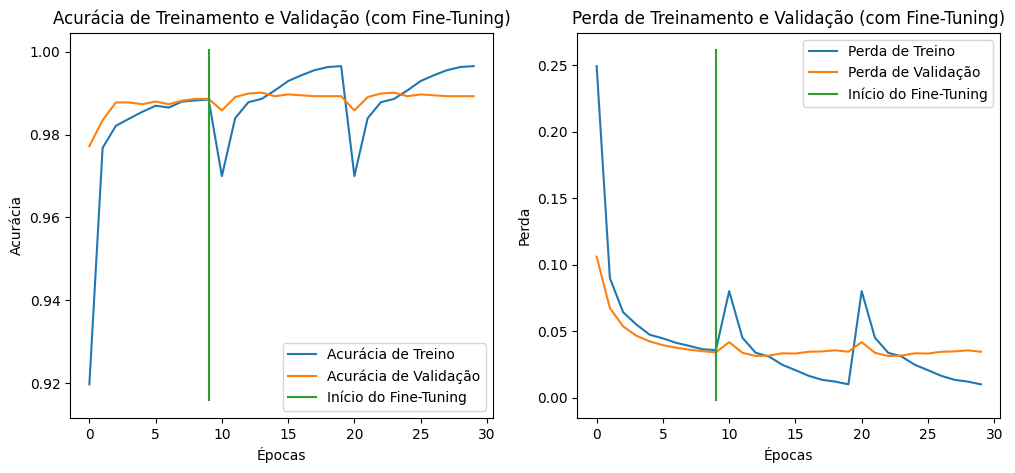

In [26]:
# Obter as métricas do treino inicial (se ainda não as tiver em 'acc', 'val_acc', etc.)
# Se a variável 'history' da primeira fase de treino ainda existir:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Adicionar as métricas do fine-tuning
# Se você chamou o resultado do fit de fine-tuning de 'history_fine':
acc += history_fine.history['accuracy'] # << CERTIFIQUE-SE QUE 'history_fine' é o nome correto
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# Calcular o range total de épocas
# initial_epochs foi o número de épocas do primeiro treino (ex: 10)
# fine_tune_epochs foi o número de épocas do fine-tuning (ex: 10)
# total_epochs = initial_epochs + fine_tune_epochs (se você definiu assim)
# Ou podemos pegar o tamanho da lista de acurácia:
epochs_range_total = range(len(acc))


# Plotar Acurácia de Treino e Validação (Combinada)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_total, acc, label='Acurácia de Treino')
plt.plot(epochs_range_total, val_acc, label='Acurácia de Validação')
# Adicionar uma linha vertical para marcar o início do fine-tuning
# SUBSTITUA 'initial_epochs' pelo número exato de épocas do seu primeiro treino (Passo 6)
# Se initial_epochs era 10, a linha deve ser em 9 (porque o range é 0-indexado)
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Início do Fine-Tuning') # << AJUSTE initial_epochs SE NECESSÁRIO
plt.legend(loc='lower right')
plt.title('Acurácia de Treinamento e Validação (com Fine-Tuning)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

# Plotar Perda de Treino e Validação (Combinada)
plt.subplot(1, 2, 2)
plt.plot(epochs_range_total, loss, label='Perda de Treino')
plt.plot(epochs_range_total, val_loss, label='Perda de Validação')
# Adicionar uma linha vertical para marcar o início do fine-tuning
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Início do Fine-Tuning') # << AJUSTE initial_epochs SE NECESSÁRIO
plt.legend(loc='upper right')
plt.title('Perda de Treinamento e Validação (com Fine-Tuning)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.show()

In [27]:
print("\nAvaliação final (pós Fine-Tuning) no conjunto de validação:")
loss_ft, accuracy_ft = model.evaluate(validation_batches) # << 'validation_batches' precisa estar definido (do Passo 3)
print("Perda na Validação (Pós Fine-Tuning):", loss_ft)
print("Acurácia na Validação (Pós Fine-Tuning):", accuracy_ft)


Avaliação final (pós Fine-Tuning) no conjunto de validação:
146/146 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9894 - loss: 0.0297
Perda na Validação (Pós Fine-Tuning): 0.034443389624357224
Acurácia na Validação (Pós Fine-Tuning): 0.9892519116401672
